# SET DESIRED EVALUATION RUNS HERE

In [1]:
MODEL = 'davinci' # 'flan-t5', 'neox' or 'davinci' (temperature is set to whatever is optimal for each model)
SHOTS = 0 # 0, 1, or 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
import seaborn as sns
from uni_kie.pdf_to_text.pdf_to_text import SroieWrapperOwnOCR, SroieWrapper
import os
import json

In [3]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2") # this is the same tokenizer that openai uses for their instructGPT model family

In [4]:
data = pd.DataFrame(columns=["filename", "text_own_ocr", "num_tokens_own_ocr", "text_sroie_ocr", "num_tokens_sroie_ocr"])

## Extracting text with own OCR (PyMuPDF)

In [5]:
sroie_wrapper_own_ocr = SroieWrapperOwnOCR()

for i in range(len(sroie_wrapper_own_ocr.data)):
    filename = sroie_wrapper_own_ocr.data[i]
    text_own_ocr = sroie_wrapper_own_ocr.get_text(filename)
    num_tokens_own_ocr = len(tokenizer(text_own_ocr)['input_ids'])
    data = pd.concat([data, pd.DataFrame({'filename': [filename], 'text_own_ocr': [text_own_ocr], 'num_tokens_own_ocr': [num_tokens_own_ocr]})], ignore_index=True)

>>>>>>>>>>>>>> LOADING test SET


Error in pixScaleAreaMap: pixd too small
Error in pixClone: pixs not defined
Error in pixCopyText: pixd not defined
Error in pixCopyInputFormat: pixd not defined
Scaling pix of size 8, 1596 by factor 0.0225564 made null pix!!
Bad pix from ImageData!
Line cannot be recognized!!
Image too small to scale!! (1x36 vs min width of 3)
Line cannot be recognized!!
Image too small to scale!! (2x36 vs min width of 3)
Line cannot be recognized!!
Image too small to scale!! (2x36 vs min width of 3)
Line cannot be recognized!!
Image too small to scale!! (2x36 vs min width of 3)
Line cannot be recognized!!
Image too small to scale!! (1x36 vs min width of 3)
Line cannot be recognized!!
Image too small to scale!! (2x36 vs min width of 3)
Line cannot be recognized!!
Image too small to scale!! (2x36 vs min width of 3)
Line cannot be recognized!!
Error in pixScaleAreaMap: pixd too small
Error in pixClone: pixs not defined
Error in pixCopyText: pixd not defined
Error in pixCopyInputFormat: pixd not defined


We can see that there are a lot of warnings which suggest that the OCR'd output may have issues. Let's look at an example:

In [6]:
data.iloc[1]["filename"]

PosixPath('/Users/ivo/PycharmProjects/Levity/unimodal-kie/uni_kie/datasets/sroie/test/input/X51006619842.jpg')

<img src="/Users/ivo/PycharmProjects/Levity/unimodal-kie/uni_kie/datasets/sroie/test/input/X51006619842.jpg" width=250>

The extracted text for this receipt is:

In [7]:
print(data.iloc[1]['text_own_ocr'])

ae.
ee
ee
Sy
i
ee te Se i
rn
pe Ae




In [8]:
data.head()

,filename,text_own_ocr,num_tokens_own_ocr,text_sroie_ocr,num_tokens_sroie_ocr
0,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"3 \@ 02\nO14,\nLIM SENG THO HARDWARE TRADING\n...",274,NaN,NaN
1,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,ae.\nee\nee\nSy\ni\nee te Se i\nrn\npe Ae\n\n,21,NaN,NaN
2,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"(481500-M)\nCW KHOO HARDWARE SDN BHD\nNO.50 , ...",330,NaN,NaN
3,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"oe\nAEON CU.\n(M) BHD (126926-H)\n+\n3RD FLR, ...",268,NaN,NaN
4,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"SANYO STATIONERY SHOP\nNO. 31G8&33G, JALAN SET...",357,NaN,NaN


In [9]:
mean = int(np.mean(data['num_tokens_own_ocr']))
median = int(np.median(data['num_tokens_own_ocr']))
std = int(np.std(data['num_tokens_own_ocr']))
min = int(np.min(data['num_tokens_own_ocr']))
max = int(np.max(data['num_tokens_own_ocr']))

print(f"mean: {mean}, median: {median}, std: {std}, min: {min}, max: {max}")

print(f"number of documents with less than 100 tokens: {len(data[data['num_tokens_own_ocr'] < 100])}")

mean: 342, median: 335, std: 115, min: 1, max: 785
number of documents with less than 100 tokens: 12


Let's look closer at the distribution of the number of tokens.

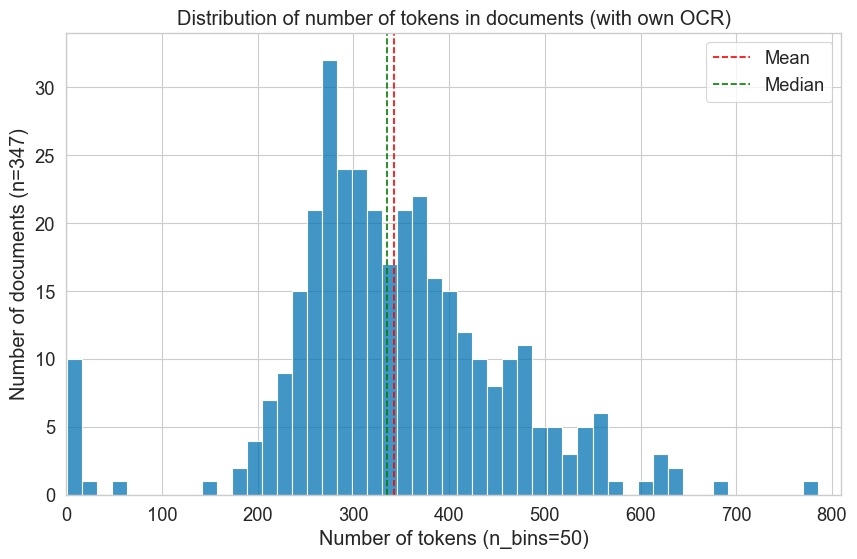

In [10]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=data, x=data["num_tokens_own_ocr"], ax=ax, bins=50)
ax.set_title("Distribution of number of tokens in documents (with own OCR)")
ax.set_xlabel(f"Number of tokens (n_bins={len(ax.patches)})")
ax.set_ylabel(f"Number of documents (n={len(data)})")
ax.axvline(data["num_tokens_own_ocr"].mean(), color="red", linestyle="--", label="Mean")
ax.axvline(data["num_tokens_own_ocr"].median(), color="green", linestyle="--", label="Median")

ax.set_xlim(0, 810)
ax.set_xticks(np.arange(0, 810, 100))

ax.set_ylim(0, 34)
ax.set_yticks(np.arange(0, 34, 5))

ax.legend()

plt.show()
fig.savefig("plots/sroie/token_distribution_own_ocr.png", dpi=300, bbox_inches="tight")

Let's look at the shortest document to get a better idea of what the input text looks like.

In [11]:
# find the shortest document
data[data['num_tokens_own_ocr'] == data['num_tokens_own_ocr'].min()]

# print the text of the shortest document
print(data[data['num_tokens_own_ocr'] == data['num_tokens_own_ocr'].min()]['text_own_ocr'].values[0])

We don't even have any text for this particular receipt.

Let's check if the text of the receipts fits in our models

In [12]:
print(f"The longest document has {data['num_tokens_own_ocr'].max()} tokens")

The longest document has 785 tokens


Great news, even the longest doc will easily fit into our smaller GPT-NeoX and Flan-T5 models (limit 1792).

Nonetheless, 12 out of the 347 documents basically don't have any extracted text. Motivated by this and the fact that potential future work should be comparable to ours, we will use the provided OCR by the data set.

## Using provided OCR

In [13]:
sroie_wrapper = SroieWrapper()

for i in range(len(sroie_wrapper.data)):
    filename = sroie_wrapper.data.iloc[i]['filename']
    text_sroie_ocr = sroie_wrapper.get_text(filename)
    num_tokens_sroie_ocr = len(tokenizer(text_sroie_ocr)['input_ids'])

    data.loc[data['filename'] == filename, 'text_sroie_ocr'] = text_sroie_ocr
    data.loc[data['filename'] == filename, 'num_tokens_sroie_ocr'] = num_tokens_sroie_ocr

>>>>>>>>>>>>>> LOADING test SET


In [14]:
data.head()

,filename,text_own_ocr,num_tokens_own_ocr,text_sroie_ocr,num_tokens_sroie_ocr
0,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"3 \@ 02\nO14,\nLIM SENG THO HARDWARE TRADING\n...",274,LIM SENG THO HARDWARE TRADING\nNO 7. SIMPANG O...,267
1,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,ae.\nee\nee\nSy\ni\nee te Se i\nrn\npe Ae\n\n,21,"YIN MA (M) SDN.BHD.(974306-T)\nNO.2, JALAN UDA...",285
2,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"(481500-M)\nCW KHOO HARDWARE SDN BHD\nNO.50 , ...",330,"(481500-M)\nC W KHOO HARDWARE SDN BHD\nNO.50 ,...",333
3,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"oe\nAEON CU.\n(M) BHD (126926-H)\n+\n3RD FLR, ...",268,"AEON CO. (M) BHD (126926-H)\n3RD FLR, AEON TAM...",272
4,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"SANYO STATIONERY SHOP\nNO. 31G8&33G, JALAN SET...",357,"SANYU STATIONERY SHOP\nNO. 31G&33G, JALAN SETI...",365


In [15]:
mean = int(np.mean(data['num_tokens_sroie_ocr']))
median = int(np.median(data['num_tokens_sroie_ocr']))
std = int(np.std(data['num_tokens_sroie_ocr']))
min = int(np.min(data['num_tokens_sroie_ocr']))
max = int(np.max(data['num_tokens_sroie_ocr']))

print(f"mean: {mean}, median: {median}, std: {std}, min: {min}, max: {max}")

print(f"number of documents with less than 100 tokens: {len(data[data['num_tokens_sroie_ocr'] < 100])}")

mean: 346, median: 324, std: 93, min: 160, max: 675
number of documents with less than 100 tokens: 0


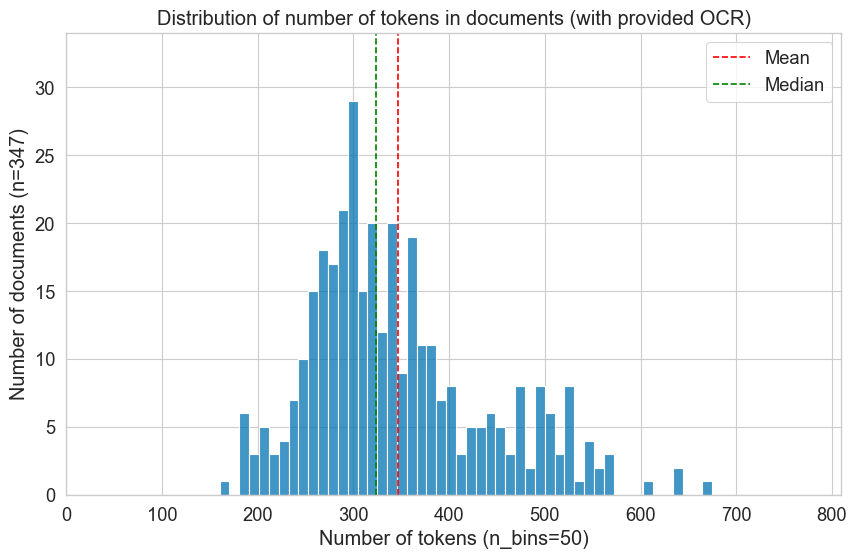

In [16]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=data, x=data["num_tokens_sroie_ocr"], ax=ax, bins=50)
ax.set_title("Distribution of number of tokens in documents (with provided OCR)")
ax.set_xlabel(f"Number of tokens (n_bins={len(ax.patches)})")
ax.set_ylabel(f"Number of documents (n={len(data)})")
ax.axvline(data["num_tokens_sroie_ocr"].mean(), color="red", linestyle="--", label="Mean")
ax.axvline(data["num_tokens_sroie_ocr"].median(), color="green", linestyle="--", label="Median")

ax.set_xlim(0, 810)
ax.set_xticks(np.arange(0, 810, 100))

ax.set_ylim(0, 34)
ax.set_yticks(np.arange(0, 34, 5))

ax.legend()

plt.show()
fig.savefig("plots/sroie/token_distribution_sroie_ocr.png", dpi=300, bbox_inches="tight")

In [17]:
# let's look at the text of the shortest document
print(data[data['num_tokens_sroie_ocr'] == data['num_tokens_sroie_ocr'].min()]['text_sroie_ocr'].values[0])

CONTENTO (JM0761170-K)
15, JALAN PERMAS 10/7, PERMAS
81750 MASAI JOHOR
20/03/18 17:19
000000#001429
2X 5.90
RM
11.80
BUBBLE M T
1X 4.90
RM
4.90
YAM M T
1X 1.00
RM
1.00
ADD ON
1X 3.90
RM
3.90
W.CHO
ITEMS 50
***TOTAL
RM
21.60
CASH
RM
30.00
CHANGE
RM
8.40
THANK YOU
FORWARD TO YOUR NEXT VISIT


In [18]:
print(f"The longest document has {data['num_tokens_sroie_ocr'].max()} tokens")

The longest document has 675 tokens


## Exploring whether all keys are given in the gold standard (Loading Gold)

In [19]:
path_to_sroie = "./datasets/sroie/test/"

In [20]:
path_to_gold_standard = path_to_sroie + "gold/"

keys = ["company", "date", "address", "total"]

gold_standard = {}
for filename in os.listdir(path_to_gold_standard):
    with open(os.path.join(path_to_gold_standard, filename), 'r') as f:
        gold_standard[filename] = json.load(f)

for filename, file in gold_standard.items():
    for key in keys:
        if key not in file:
            print(f"{key} is not in {filename}")
        elif file[key] == "":
            print(f"{key} in {filename} is an empty string")

In [21]:
gold_standard_df = pd.DataFrame.from_dict(gold_standard, orient='index')

In [22]:

if MODEL == 'flan-t5':
    if SHOTS == 0:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-26-54_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-26-56_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-29-59_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=False)',
        ]

    elif SHOTS == 1:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-33-13_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-33-17_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-35-11_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=True)',
        ]

    elif SHOTS == 2:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/flan-t5/2023-01-25T22-00-26_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T22-00-28_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T22-00-33_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=TWOSHOT)',
        ]

elif MODEL == 'neox':
    if SHOTS == 0:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/neox/2023-01-25T19-27-04_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/neox/2023-01-25T19-28-11_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/neox/2023-01-25T19-28-15_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
        ]

    elif SHOTS == 1:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/neox/2023-01-25T22-17-14_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/neox/2023-01-25T22-17-15_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/neox/2023-01-25T22-17-18_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
        ]

    elif SHOTS == 2:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/neox/2023-01-25T22-18-33_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/neox/2023-01-25T22-18-36_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/neox/2023-01-25T22-18-39_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
        ]

elif MODEL == 'davinci':
    if SHOTS == 0:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/davinci/2023-01-26T18-29-10_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/davinci/2023-01-26T19-02-22_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-22-26_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
        ]

    elif SHOTS == 1:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/davinci/2023-01-27T12-22-44_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-22-46_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-22-48_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
        ]

    elif SHOTS == 2:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/davinci/2023-01-27T12-23-09_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-23-11_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-23-13_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
        ]


In [23]:
predictions_runs_dfs = []
for path in PREDICTION_RUNS_PATHS:
    predictions_run = {}
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r') as f:
            predictions_run[filename] = json.load(f)


    predictions_run_df = pd.DataFrame.from_dict(predictions_run, orient='index')
    predictions_run_df = predictions_run_df.reindex(columns=gold_standard_df.columns, fill_value=np.nan)
    predictions_runs_dfs.append(predictions_run_df)


In [24]:
predictions_runs_dfs[0].head()

,company,date,address,total
X51005675104.txt,SYARIKAT PERNIAGAAN GIN KEE,25/01/2018,"NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA...",190.80
X51005568890.txt,HON HWA HARDWARE TRADING,05/01/2017,"NO 37, JALAN MANIS 7, TAMAN SEGAR, 56100 CHERA...",5.00
X00016469670.txt,OJC MARKETING SDN BHD,15/01/2019 11:05:16 AM,"NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, 8175...",193.00
X51006557507.txt,Makassar Fresh Market Sdn Bhd,27/10/2017,"Ground Floor, No. 4 & 6, Jalan SS 15/4B, 47500...",35.88
X51007846396.txt,GERBANG ALAF RESTAURANTS SDN BHD,24/06/2018 22:40:45,"LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3, NO.3,...",7.35


In [25]:
# how often was a given key predicted?
predictions_runs_dfs[0].count()

company    347
date       347
address    347
total      347
dtype: int64

In [26]:
eval_dfs = []
for predictions_run_df in predictions_runs_dfs:
    eval_df = pd.DataFrame()
    for index, row in predictions_run_df.iterrows():
        for key in keys:
            if row[key] == gold_standard_df.loc[index][key]:
                eval_df.loc[index, key] = 1
            else:
                eval_df.loc[index, key] = 0

    for index, row in gold_standard_df.iterrows():
        if index not in eval_df.index:
            eval_df.loc[index] = 0

    eval_dfs.append(eval_df)

In [27]:
# overall accuracy of the model
# i.e. the fraction of gold values which are predicted correctly
accuracy_by_key = []
overall_accuracy = []
for eval_df in eval_dfs:
    accuracy_by_key.append(eval_df.mean())
    overall_accuracy.append(eval_df.mean().mean())

for key in keys:
    print(f"Accuracy for {key}: {round(np.mean([accuracy_by_key[i][key] for i in range(len(accuracy_by_key))]), 3)}±{round(np.std([accuracy_by_key[i][key] for i in range(len(accuracy_by_key))], ddof=1), 3)}")
print(f"Overall accuracy: {round(np.mean(overall_accuracy), 3)}±{round(np.std(overall_accuracy, ddof=1), 3)}")


Accuracy for company: 0.479±0.006
Accuracy for date: 0.584±0.002
Accuracy for address: 0.333±0.01
Accuracy for total: 0.845±0.006
Overall accuracy: 0.561±0.005


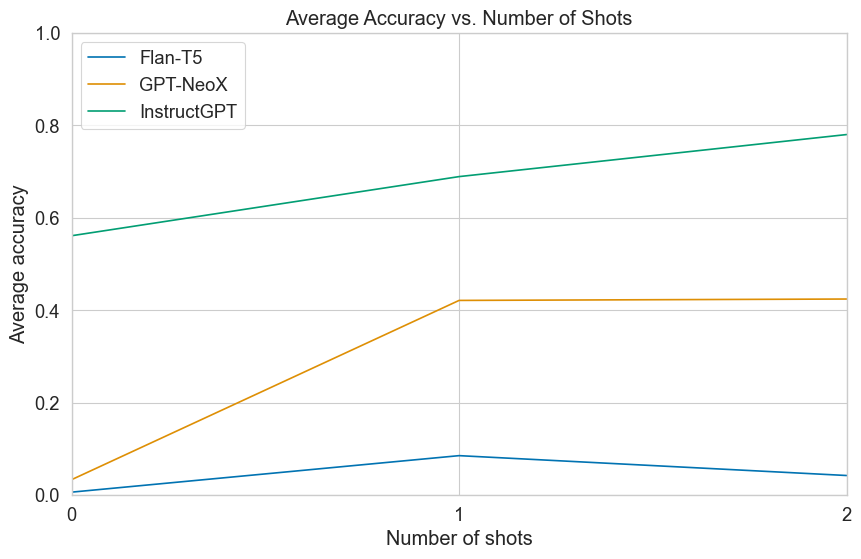

In [28]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

# shots 
x = [0, 1, 2]

# overall accuracy
y_flan_t5 = [0.006, 0.085, 0.042]
y_neox = [0.033, 0.421, 0.424]
y_davinci = [0.561, 0.689, 0.780]

# plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y_flan_t5, label='Flan-T5')
ax.plot(x, y_neox, label='GPT-NeoX')
ax.plot(x, y_davinci, label='InstructGPT')



# set ticks
ax.set_xticks(x)
ax.set_xlim(0, 2)

ax.set_ylim(0, 1)

ax.set(xlabel="Number of shots", ylabel="Average accuracy", title="Average Accuracy vs. Number of Shots")
ax.legend(loc='upper left')

plt.show()
fig.savefig(f"plots/sroie/accuracy_vs_shots.png", dpi=300, bbox_inches='tight')
